# Imports & Extracting Data

In [ ]:
!pip install -q kaggle
!pip install Augmentor

# Upload kaggle.json
from google.colab import files
files.upload()

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d nodoubttome/skin-cancer9-classesisic

# Unzip the dataset
import zipfile
with zipfile.ZipFile("skin-cancer9-classesisic.zip", "r") as zip_ref:
    zip_ref.extractall("skin_cancer_data")

import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import Augmentor
import tensorflow as tf
import numpy as np
from collections import Counter, defaultdict
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm


print("Extracted folders:", os.listdir("skin_cancer_data"))

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic
License(s): other
Extracted folders: ['Skin cancer ISIC The International Skin Imaging Collaboration']


# Evaluation Function

In [ ]:
def evaluate_per_class_accuracy(model, dataset, class_names):
    true_labels = []
    pred_labels = []

    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        preds = tf.argmax(preds, axis=1)
        true_labels.extend(labels.numpy())
        pred_labels.extend(preds.numpy())

    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    per_class_acc = {}
    for i, name in enumerate(class_names):
        mask = true_labels == i
        correct = np.sum(pred_labels[mask] == true_labels[mask])
        total = np.sum(mask)
        acc = correct / total if total > 0 else 0
        per_class_acc[name] = acc

    return per_class_acc


# Preprocessing

In [ ]:
#Paths
base_path = "skin_cancer_data/Skin cancer ISIC The International Skin Imaging Collaboration"
train_path = os.path.join(base_path, "Train")
test_path = os.path.join(base_path, "Test")
val_path = os.path.join(base_path, "Validation")

#Directory for when images are augmented through image flipping, random amounts of brightness, zooming, and contrast
augmented_output_dir = '/content/augmented_data/'
os.makedirs(augmented_output_dir, exist_ok=True)

# List class folders to verify
class_names = os.listdir(train_path)
print("Classes found:", class_names)

# Augment images
def augment_class_images(source_dir, output_dir, num_samples=1000):
    p = Augmentor.Pipeline(source_directory=source_dir, output_directory=output_dir)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.5)
    p.zoom_random(probability=0.5, percentage_area=0.9)
    p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
    p.random_contrast(probability=0.5, min_factor=0.75, max_factor=1.25)
    p.sample(num_samples)

for class_name in class_names:
    class_input_dir = os.path.join(train_path, class_name)
    class_output_dir = os.path.join(augmented_output_dir, class_name, 'output')
    os.makedirs(class_output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(class_input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Augmenting {class_name} with {len(image_files)} images...")

    augment_class_images(class_input_dir, class_output_dir, num_samples=1000)

Classes found: ['squamous cell carcinoma', 'basal cell carcinoma', 'melanoma', 'dermatofibroma', 'nevus', 'vascular lesion', 'seborrheic keratosis', 'pigmented benign keratosis', 'actinic keratosis']
Augmenting squamous cell carcinoma with 181 images...
Initialised with 181 image(s) found.
Output directory set to /content/augmented_data/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E93BC5C1150>: 100%|██████████| 1000/1000 [00:10<00:00, 94.93 Samples/s]


Augmenting basal cell carcinoma with 376 images...
Initialised with 376 image(s) found.
Output directory set to /content/augmented_data/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E93C09B8110>: 100%|██████████| 1000/1000 [00:08<00:00, 111.86 Samples/s]


Augmenting melanoma with 438 images...
Initialised with 438 image(s) found.
Output directory set to /content/augmented_data/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E93BC4FC790>: 100%|██████████| 1000/1000 [00:47<00:00, 21.18 Samples/s]


Augmenting dermatofibroma with 95 images...
Initialised with 95 image(s) found.
Output directory set to /content/augmented_data/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E93BC551A50>: 100%|██████████| 1000/1000 [00:09<00:00, 109.28 Samples/s]


Augmenting nevus with 357 images...
Initialised with 357 image(s) found.
Output directory set to /content/augmented_data/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7E93C25FA8D0>: 100%|██████████| 1000/1000 [00:45<00:00, 22.06 Samples/s]


Augmenting vascular lesion with 139 images...
Initialised with 139 image(s) found.
Output directory set to /content/augmented_data/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E947A8F5310>: 100%|██████████| 1000/1000 [00:08<00:00, 113.17 Samples/s]


Augmenting seborrheic keratosis with 77 images...
Initialised with 77 image(s) found.
Output directory set to /content/augmented_data/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E93C09B8910>: 100%|██████████| 1000/1000 [00:21<00:00, 47.46 Samples/s]


Augmenting pigmented benign keratosis with 462 images...
Initialised with 462 image(s) found.
Output directory set to /content/augmented_data/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E93C0D7BD90>: 100%|██████████| 1000/1000 [00:08<00:00, 115.00 Samples/s]


Augmenting actinic keratosis with 114 images...
Initialised with 114 image(s) found.
Output directory set to /content/augmented_data/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E93C0BBA410>: 100%|██████████| 1000/1000 [00:08<00:00, 114.68 Samples/s]


In [ ]:
#Preprocessing data
train_ds = tf.keras.utils.image_dataset_from_directory(
    augmented_output_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    augmented_output_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(180, 180),
    batch_size=32
)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.
Found 9000 files belonging to 9 classes.
Using 1800 files for validation.
Found 118 files belonging to 9 classes.


In [ ]:
# Get all labels from the validation set
val_labels = []
for images, labels in val_ds.unbatch():
    val_labels.append(labels.numpy())

# Count the number of samples per class
val_counts = Counter(val_labels)

# Print sorted by class index with class names
for class_index in sorted(val_counts):
    class_name = class_names[class_index]
    print(f"{class_name}: {val_counts[class_index]} samples")

squamous cell carcinoma: 198 samples
basal cell carcinoma: 219 samples
melanoma: 206 samples
dermatofibroma: 199 samples
nevus: 202 samples
vascular lesion: 190 samples
seborrheic keratosis: 190 samples
pigmented benign keratosis: 209 samples
actinic keratosis: 187 samples


Display Images

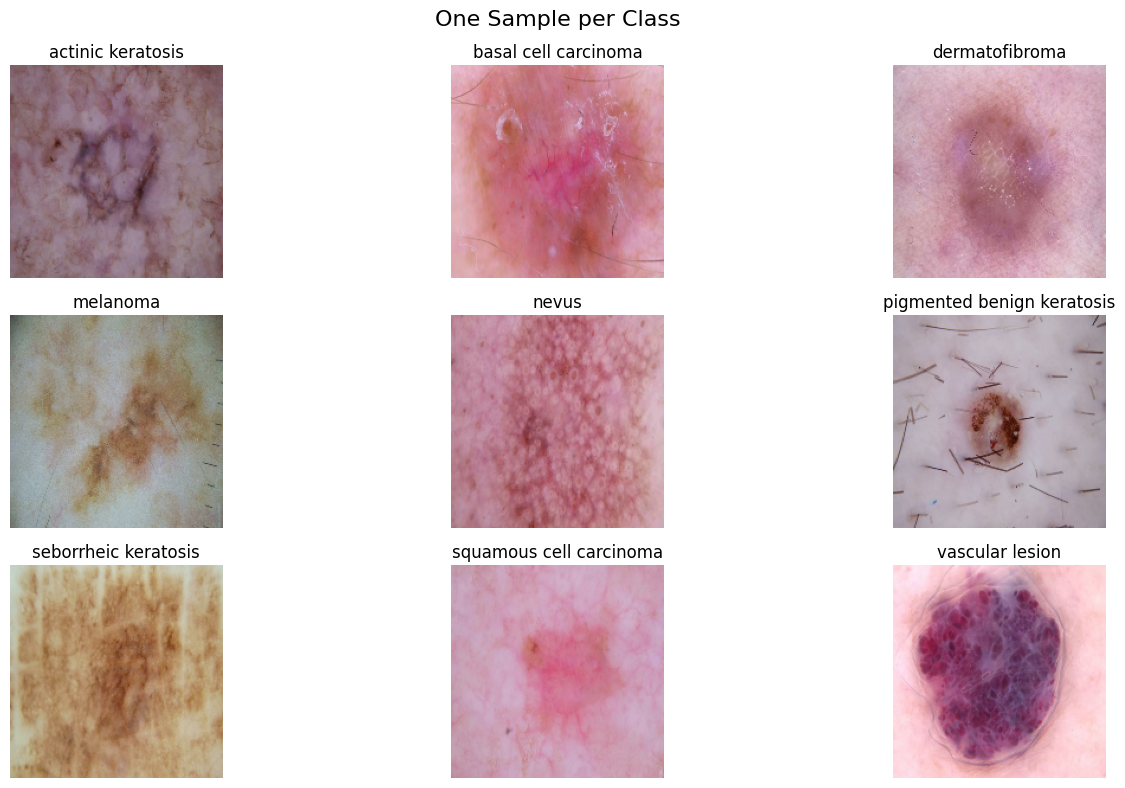

In [ ]:
# Make sure class_names are sorted to match label indices
class_names = sorted(os.listdir(train_path))

# Initialize a dictionary to hold one image per class
class_images = {}
for images, labels in train_ds.unbatch():
    label = labels.numpy()
    if label not in class_images:
        class_images[label] = images.numpy() / 255.0  # Rescale for display
    if len(class_images) == len(class_names):
        break

# Plot one image per class
plt.figure(figsize=(15, 8))
for i, label in enumerate(sorted(class_images)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(class_images[label])
    plt.title(f"{class_names[label]}")
    plt.axis("off")
plt.suptitle("One Sample per Class", fontsize=16)
plt.tight_layout()
plt.show()


# Model 1

Model Architecture (for Model 1 and Model 2)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache("/tmp/cache").shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


def build_model(input_shape=(180, 180, 3), num_classes=9):
    return Sequential([
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(32, 3, padding="same", activation='relu'),
        MaxPool2D(),

        Conv2D(64, 3, padding="same", activation='relu'),
        MaxPool2D(),

        Conv2D(128, 3, padding="same", activation='relu'),
        MaxPool2D(),
        Dropout(0.15),

        Conv2D(256, 3, padding="same", activation='relu'),
        MaxPool2D(),
        Dropout(0.20),

        Conv2D(512, 3, padding="same", activation='relu'),
        MaxPool2D(),
        Dropout(0.25),

        Flatten(),
        Dense(1024, activation="relu"),
        Dense(num_classes, activation='softmax')
    ])

model1 = build_model()
model2 = build_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model 1 Training

In [ ]:
def get_callbacks():
    return [
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]
opt = Adam(learning_rate=5e-4)

model1.compile(
    optimizer=opt,
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train it
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=get_callbacks()
)


Epoch 1/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - accuracy: 0.1978 - loss: 2.0386 - val_accuracy: 0.3700 - val_loss: 1.5601 - learning_rate: 5.0000e-04
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.4012 - loss: 1.5228 - val_accuracy: 0.4311 - val_loss: 1.4547 - learning_rate: 5.0000e-04
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.4650 - loss: 1.3738 - val_accuracy: 0.4817 - val_loss: 1.3332 - learning_rate: 5.0000e-04
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.5061 - loss: 1.2754 - val_accuracy: 0.5200 - val_loss: 1.2460 - learning_rate: 5.0000e-04
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.5575 - loss: 1.1634 - val_accuracy: 0.5428 - val_loss: 1.2010 - learning_rate: 5.0000e-04
Epoch 6/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.5998 - loss: 1.0720 - val_accuracy: 0.5700 - val_loss: 1.1370 - learning_rate: 5.0000e-04
Epoch 7/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/ste

Model 1 Results (Clean Data)

In [ ]:
class_names = sorted(os.listdir(train_path))
num_classes = len(class_names)

# Initialize
true_labels = []
pred_labels = []

# Collect predictions and labels
for images, labels in val_ds:
    preds = model1.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    true_labels.extend(labels.numpy())
    pred_labels.extend(pred_classes)

# Convert to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Compute per-class accuracy
class_accuracies = {}
for class_idx in range(num_classes):
    class_mask = true_labels == class_idx
    correct_preds = np.sum(pred_labels[class_mask] == true_labels[class_mask])
    total_preds = np.sum(class_mask)
    accuracy = correct_preds / total_preds if total_preds > 0 else 0
    class_accuracies[class_idx] = accuracy

# Print results with class names
for class_idx, acc in class_accuracies.items():
    class_name = class_names[class_idx]
    print(f"Class {class_idx} ({class_name}) Accuracy: {acc:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

---
**Adversarial Attack**

*Conducting an adversarial attack on validation data. We will then demonstrate that the validation accuracy worsens for our baseline model that is not trained on these slightly different images.*



In [ ]:
#Spatial transform function
def random_spatial_transform(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    img = tf.image.random_brightness(img, max_delta=0.2)
    dx = tf.random.uniform([], -10, 10, dtype=tf.int32)
    dy = tf.random.uniform([], -10, 10, dtype=tf.int32)
    img = tf.roll(img, shift=[dy, dx], axis=[0, 1])
    img = tf.clip_by_value(img, 0, 255)
    return tf.cast(img, tf.float32)

def generate_worst_case_batch(images, labels, model, N=10):
    worst_images = []
    new_labels = []
    for i in range(len(images)):
        original_img = images[i]
        label = int(labels[i].numpy())
        min_confidence = 1.0
        worst_img = original_img
        for _ in range(N):
            transformed = random_spatial_transform(original_img)
            transformed = tf.expand_dims(transformed, axis=0)
            pred = model(transformed, training=False)[0]
            confidence = pred[label].numpy()
            if confidence < min_confidence:
                min_confidence = confidence
                worst_img = transformed[0]
        worst_images.append(worst_img)
        new_labels.append(label)
    return tf.stack(worst_images), tf.constant(new_labels)

def save_image(img_tensor, filepath):
    img = tf.clip_by_value(img_tensor, 0, 255)
    img = tf.cast(img, tf.uint8)
    Image.fromarray(img.numpy()).save(filepath)

def generate_and_save_clean_and_adv_images_separate_dirs(dataset, class_names, clean_dir, adv_dir, model, prefix=""):
    os.makedirs(clean_dir, exist_ok=True)
    os.makedirs(adv_dir, exist_ok=True)
    for batch_idx, (images, labels) in tqdm(enumerate(dataset), total=len(dataset), desc=f"Saving {prefix} clean + adv"):
        images = tf.cast(images, tf.float32)
        for i, (img, label) in enumerate(zip(images, labels)):
            class_name = class_names[int(label.numpy())]
            save_path = os.path.join(clean_dir, class_name)
            os.makedirs(save_path, exist_ok=True)
            save_image(img, os.path.join(save_path, f"{prefix}clean_{batch_idx}_{i}.jpg"))
        adv_images, _ = generate_worst_case_batch(images, labels, model)
        for i, (adv_img, label) in enumerate(zip(adv_images, labels)):
            class_name = class_names[int(label.numpy())]
            save_path = os.path.join(adv_dir, class_name)
            os.makedirs(save_path, exist_ok=True)
            save_image(adv_img, os.path.join(save_path, f"{prefix}adv_{batch_idx}_{i}.jpg"))

generate_and_save_clean_and_adv_images_separate_dirs(
    dataset=val_ds,
    class_names=class_names,
    clean_dir="saved_val_clean",
    adv_dir="saved_val_adv",
    model=model1,
    prefix="val_"
)


Saving val_ clean + adv: 100%|██████████| 57/57 [05:51<00:00,  6.16s/it]


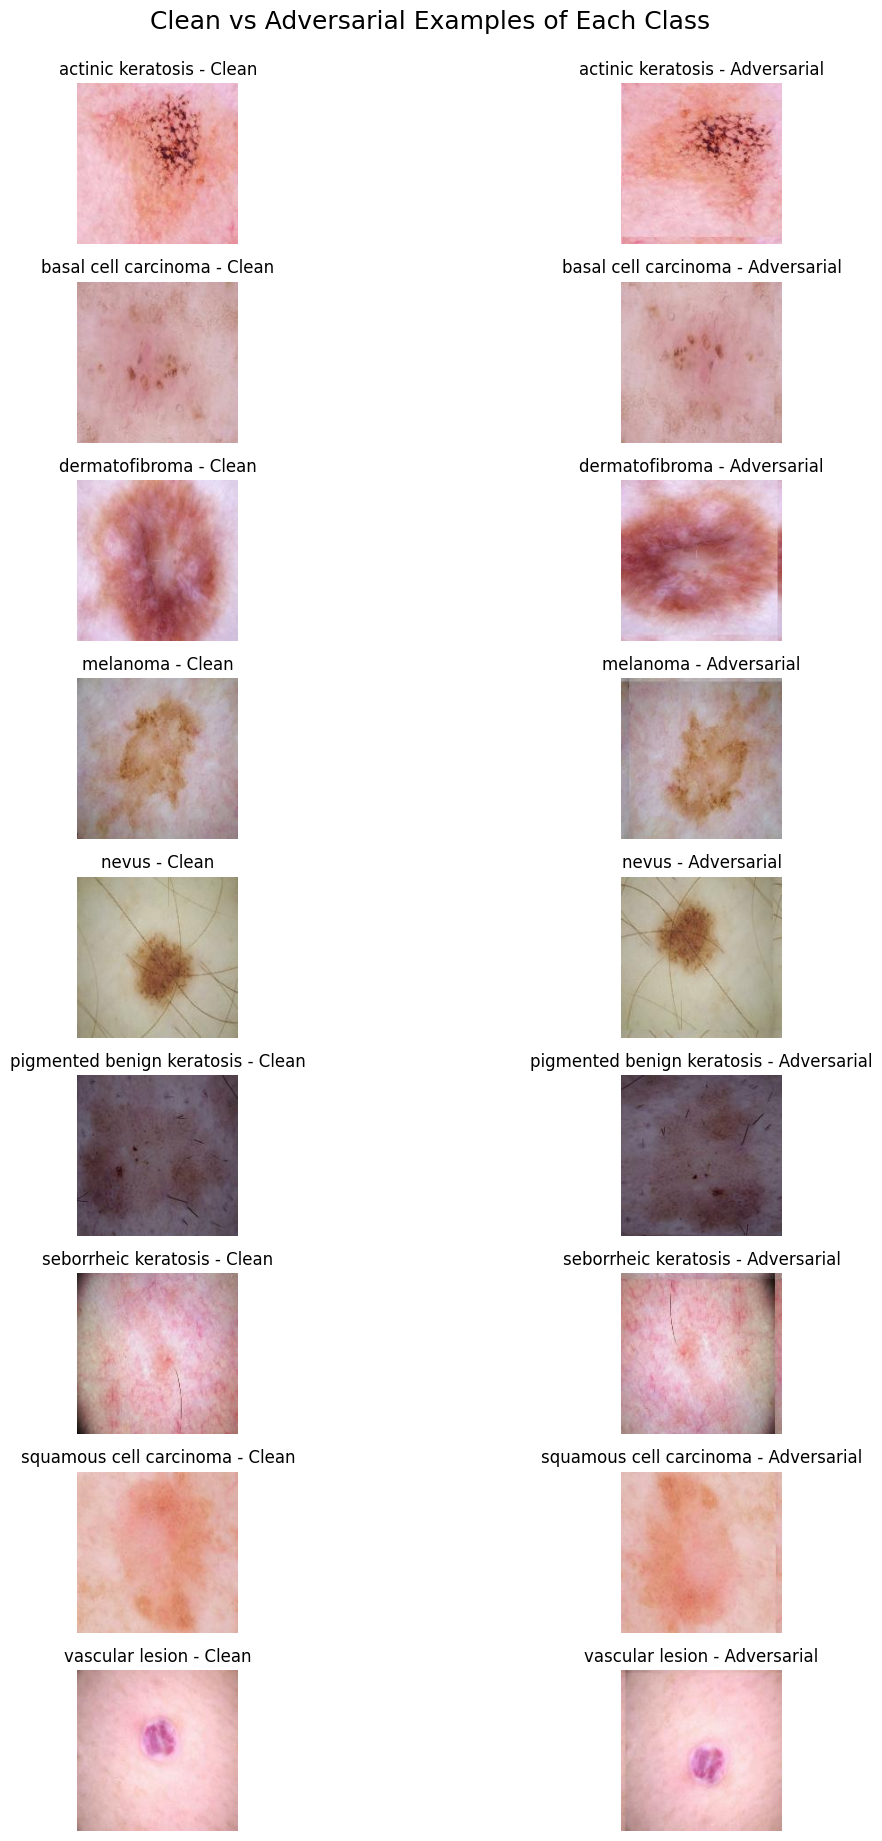

In [ ]:
# Directories
clean_dir = "saved_val_clean"
adv_dir = "saved_val_adv"

# Sorted class names
class_names = sorted(os.listdir(clean_dir))
num_classes = len(class_names)

# Prepare figure
plt.figure(figsize=(15, num_classes * 2))

for i, class_name in enumerate(class_names):
    # clean
    clean_class_path = os.path.join(clean_dir, class_name)
    clean_img_files = sorted([f for f in os.listdir(clean_class_path) if f.startswith("val_clean_")])
    if clean_img_files:
        clean_img = Image.open(os.path.join(clean_class_path, clean_img_files[0])).convert("RGB")
        clean_img = np.array(clean_img).astype(np.float32) / 255.0
        plt.subplot(num_classes, 2, 2*i + 1)
        plt.imshow(clean_img)
        plt.title(f"{class_name} - Clean")
        plt.axis("off")

    # adversarial
    adv_class_path = os.path.join(adv_dir, class_name)
    adv_img_files = sorted([f for f in os.listdir(adv_class_path) if f.startswith("val_adv_")])
    if adv_img_files:
        adv_img = Image.open(os.path.join(adv_class_path, adv_img_files[0])).convert("RGB")
        adv_img = np.array(adv_img).astype(np.float32) / 255.0
        plt.subplot(num_classes, 2, 2*i + 2)
        plt.imshow(adv_img)
        plt.title(f"{class_name} - Adversarial")
        plt.axis("off")

plt.tight_layout()
plt.suptitle("Clean vs Adversarial Examples of Each Class", fontsize=18, y=1.02)
plt.show()

Model 1 Evaluation on Adversarial Data

In [ ]:
val_clean_ds = tf.keras.utils.image_dataset_from_directory(
    "saved_val_clean",
    image_size=(180, 180),
    batch_size=32,
    shuffle=False
)

val_adv_ds = tf.keras.utils.image_dataset_from_directory(
    "saved_val_adv",
    image_size=(180, 180),
    batch_size=32,
    shuffle=False
)

class_names = sorted(os.listdir("saved_val_clean"))
# Evaluate the original model (model1) on clean and adversarial test sets
clean_per_class_model1 = evaluate_per_class_accuracy(model1, val_clean_ds, class_names)
adv_per_class_model1 = evaluate_per_class_accuracy(model1, val_adv_ds, class_names)

print("Per-Class Accuracy Comparison for Original Model (model1):\n")
for class_name in class_names:
    clean_acc = clean_per_class_model1.get(class_name, 0)
    adv_acc = adv_per_class_model1.get(class_name, 0)
    print(f"{class_name:<30} Clean = {clean_acc:.2%} | Adversarial = {adv_acc:.2%}")

Found 1800 files belonging to 9 classes.
Found 1800 files belonging to 9 classes.
Per-Class Accuracy Comparison for Original Model (model1):

actinic keratosis              Clean = 86.36% | Adversarial = 4.55%
basal cell carcinoma           Clean = 79.00% | Adversarial = 26.48%
dermatofibroma                 Clean = 92.23% | Adversarial = 6.31%
melanoma                       Clean = 56.28% | Adversarial = 7.54%
nevus                          Clean = 73.76% | Adversarial = 34.16%
pigmented benign keratosis     Clean = 74.74% | Adversarial = 23.16%
seborrheic keratosis           Clean = 92.63% | Adversarial = 15.26%
squamous cell carcinoma        Clean = 80.86% | Adversarial = 3.35%
vascular lesion                Clean = 98.40% | Adversarial = 75.40%


# **Model 2 (to be trained on adversarial data)**

In [ ]:
# Create training data (clean + adversarial) for model2
generate_and_save_clean_and_adv_images_separate_dirs(
    dataset=train_ds,
    class_names=class_names,
    clean_dir="augmented_train_clean",
    adv_dir="augmented_train_adv",
    model=model1,
    prefix="train_"
)

Saving train_ clean + adv: 100%|██████████| 225/225 [23:23<00:00,  6.24s/it]


Retrieve Image Data

In [ ]:
#Retrieving the data
train_clean_ds = tf.keras.utils.image_dataset_from_directory(
    "augmented_train_clean",
    image_size=(180, 180),
    batch_size=32,
    shuffle=True
)

train_adv_ds = tf.keras.utils.image_dataset_from_directory(
    "augmented_train_adv",
    image_size=(180, 180),
    batch_size=32,
    shuffle=True
)

# Combine clean and adversarial batches
train_ds = tf.data.Dataset.sample_from_datasets(
    [train_clean_ds, train_adv_ds],
    weights=[0.5, 0.5],
    seed=123
)

Found 7200 files belonging to 9 classes.
Found 7200 files belonging to 9 classes.


Model 2 Training

In [ ]:
opt = Adam(learning_rate=5e-4)

model2.compile(
    optimizer=opt,
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train
history = model2.fit(
    train_ds,
    validation_data=val_clean_ds,
    epochs=25,
    callbacks=get_callbacks()
)

Epoch 1/25
    449/Unknown 24s 43ms/step - accuracy: 0.8749 - loss: 0.3552

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.8749 - loss: 0.3552 - val_accuracy: 0.7378 - val_loss: 0.8650 - learning_rate: 5.0000e-04
Epoch 2/25
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8947 - loss: 0.2972 - val_accuracy: 0.7533 - val_loss: 0.8424 - learning_rate: 5.0000e-04
Epoch 3/25
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9015 - loss: 0.2707 - val_accuracy: 0.7789 - val_loss: 0.7677 - learning_rate: 5.0000e-04
Epoch 4/25
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9060 - loss: 0.2654 - val_accuracy: 0.7922 - val_loss: 0.7548 - learning_rate: 5.0000e-04
Epoch 5/25
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9279 - loss: 0.1996 - val_accuracy: 0.7756 - val_loss: 0.8815 - learning_rate: 5.0000e-04
Epoch 6/25
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9257 - loss: 0.2206 - val_accuracy: 0.7828 - val_loss: 0.8130 - learning_rate: 5.0000e-04
Epoch 7/25
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accurac

# Compare Model 1 and Model 2

Class Name                   Model1 Clean      Model1 Adv    Model2 Clean      Model2 Adv
-------------------------------------------------------------------------------------
actinic keratosis                 87.88%          4.55%         83.84%         79.80%
basal cell carcinoma              79.91%         26.48%         80.82%         73.52%
dermatofibroma                    94.17%          6.31%         96.60%         92.23%
melanoma                          56.78%          7.54%         67.84%         55.78%
nevus                             75.25%         34.16%         76.24%         74.75%
pigmented benign keratosis         78.42%         23.16%         76.32%         63.16%
seborrheic keratosis              93.16%         15.26%         90.53%         93.68%
squamous cell carcinoma           83.25%          3.35%         81.82%         69.38%
vascular lesion                   98.40%         75.40%         98.40%         96.79%


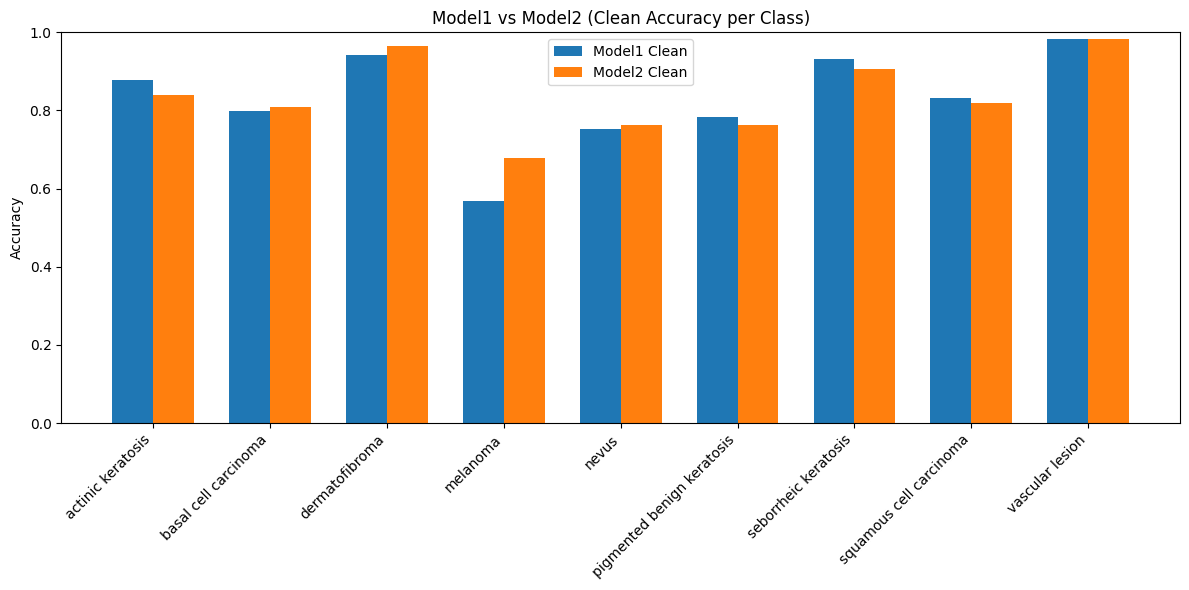

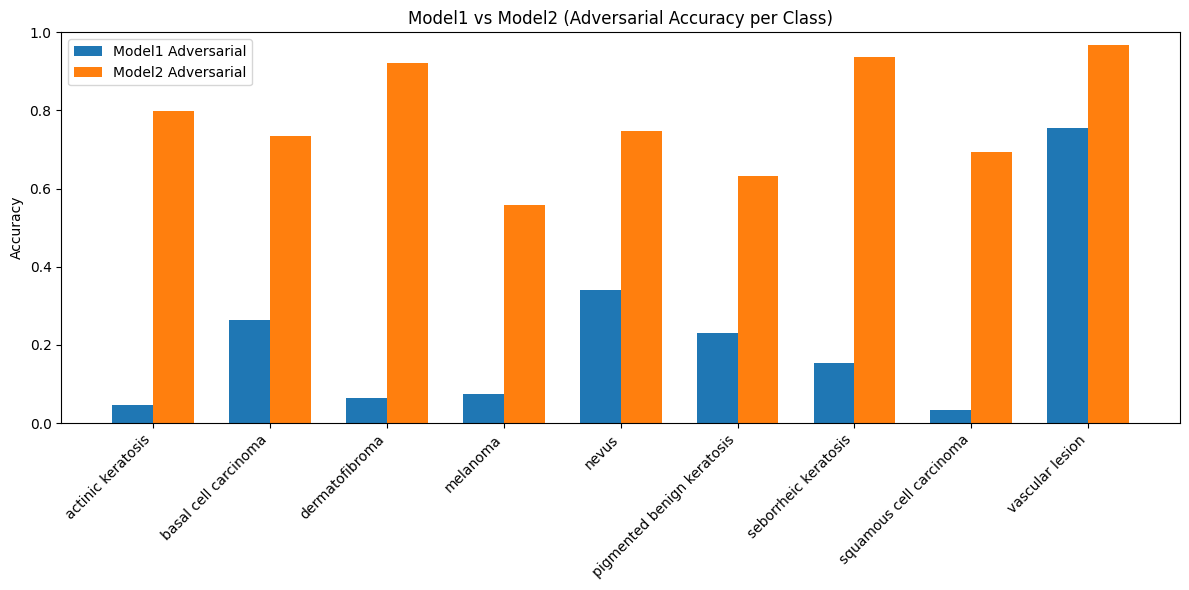

In [ ]:
class_names = sorted(os.listdir("saved_val_clean"))

# Evaluate
clean_per_class = evaluate_per_class_accuracy(model2, val_clean_ds, class_names)
adv_per_class = evaluate_per_class_accuracy(model2, val_adv_ds, class_names)
original_per_class_clean = evaluate_per_class_accuracy(model1, val_ds, class_names)
original_per_class_adv = evaluate_per_class_accuracy(model1, val_adv_ds, class_names)

# Results table
print(f"{'Class Name':<25} {'Model1 Clean':>15} {'Model1 Adv':>15} {'Model2 Clean':>15} {'Model2 Adv':>15}")
print("-" * 85)

model1_clean = []
model2_clean = []
model2_adv = []

for class_name in class_names:
    orig_acc = original_per_class_clean.get(class_name, 0)
    orig_acc_adv = original_per_class_adv.get(class_name, 0)
    clean_acc = clean_per_class.get(class_name, 0)
    adv_acc = adv_per_class.get(class_name, 0)

    print(f"{class_name:<25} {orig_acc:>14.2%} {orig_acc_adv:>14.2%} {clean_acc:>14.2%} {adv_acc:>14.2%}")

    model1_clean.append(orig_acc)
    model2_clean.append(clean_acc)
    model2_adv.append(adv_acc)

# Model1 Clean vs Model2 Clean
x = np.arange(len(class_names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, model1_clean, width=width, label='Model1 Clean')
plt.bar(x + width/2, model2_clean, width=width, label='Model2 Clean')
plt.xticks(x, class_names, rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Model1 vs Model2 (Clean Accuracy per Class)")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

# Model1 Adversarial vs Model2 Adversarial
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, original_per_class_adv.values(), width=width, label='Model1 Adversarial')
plt.bar(x + width/2, adv_per_class.values(), width=width, label='Model2 Adversarial')
plt.xticks(x, class_names, rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Model1 vs Model2 (Adversarial Accuracy per Class)")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()